In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as plt

import matplotlib.pyplot as plt

import os 

import cnn_helper
%aimport cnn_helper
cnnh = cnn_helper.CNN_Helper()

# Convolutional Neural Networks


A Fully Connected/Dense Layer with a single unit producing a single feature at layer $\ll$ computes
$$
\y_{\llp,1} = a_\llp( \y_{(\ll-1)} \cdot \W_{\llp,1} )
$$

<div>
    <br>
    <center><strong>Fully connected, single feature</strong></center>
    <br>
<img src=images/FC_1feature.png width="60%">
    <br>
    </div>

That is: 
- It recognizes one new synthetic feature
- In the entirety ("fully" connected) of $\y_{(\ll-1)}$
- Using pattern $\W_{\llp,1}$ (same size as $\y_{(\ll-1)}$)
- To reduce $\y_{(\ll-1)}$ to a single feature.

The pattern being matched spans the entirety of the input
- Might it be useful to recognize a smaller feature that spanned only *part* of the input ?
- What if this smaller feature could occur *anywhere* in the input rather than at a fixed location ?

For example
- A "spike" in a time series
- The eye in a face

A pattern whose length was that of the entire input could recognize the smaller feature only in a *specific* place

This motivates some of the key ideas behind a Convolutional Layer.
- Recognize smaller features within the whole
- Using small patterns
- That are "slid" over the entire input
- Localizing the specific part of the input containing the smaller feature

## The spatial dimension

A small pattern (less than full length of input) can match a sub-section of input at any location.

We can imagine centering the pattern on each input element and applying the match.

The output, therefore, will be a vector of length equal to the input length.

Here is the connectivity diagram of a Convolutional Layer producing a **single** feature  at layer $\ll$
- Using a pattern of length $3$
- Eventually we will show how to produce *multiple* features
- Hence the subscript "1" in $\y_{\llp,1}$ to denote the first output feature

<div>
    <br>
    <center><strong>Convolutional layer, single feature</strong></center>
    <br>
<img src=images/Conv1d_1feature_diag.png width="30%">
    <br>
    </div>

The output vector $\y_{\llp,1}$ is called the first **feature map** as it attempts to match the first feature at each input location.

We refer to the indices of the feature map as the **spatial dimensions**

Thus, the output of layer $\ll$ is 2 (or higher !) dimensional when layer $\ll$ is a CNN
- a number of features
    - we have only shown a single feature thus far
- each feature producing a feature map
    - a feature map dimensions are called the spatial dimensions


The output of a CNN layer is a collection of
- $n_\llp$ feature maps (one per feature)
- each feature map having the same spatial dimension as its inputs

We can connect multiple CNN layers in sequence
- preserving the spatial dimensions across layers
- but creating more complex features as we get deeper

**Technical note: special case**
- The input to the first CNN layer $\ll$ is often a one-dimensional vector of $n_{(\ll-1)}$ features
- A CNN treats this as a $(n_{(\ll-1)} \times 1)$ vector
    - 1 feature of a 1D spatial dimensions of shape $((n_{(\ll-1)},)$ 


Our convention will be that the **feature dimension** will appear as the **final** dimension of the output of layer $\ll$.
- all prior dimensions will be part of the **spatial dimension**

We need to distinguish which dimension is the feature dimension because
- **A convolution finds small patterns in the spatial dimension, not the feature dimension**

To be clear
- the vector of shape $(1 \times \dim)$ denotes $\dim$ features at a single spatial location
- the vector of shape $(\dim \times 1)$ denotes  a single features at  $\dim$ spatial locations


**Notation**
- the feature dimension will be the last index
- $n_\llp$ will always denote the *number of features* of a layer $\ll$
- $\y_{\llp, j', j}$ denotes feature $j$ of layer $\ll$ at spatial location $j'$

We say that the above convolutional layer $\ll$
- Maps a single feature (defined over a 1D spatial dimension with $\dim_\llp = \dim_{(\ll-1)}$ locations) of layer $(\ll-1)$
- To a single feature, defined over an identical number of spatial locations in layer $\ll$

## The importance of the spatial dimension

Let's contrast the CNN layer with a Fully Connected layer.

- The Fully Connected layer we depicted matches a pattern over the full *feature* dimension
    - There is no ordering (or spatial relationship) between features
- The CNN layer we depicted matches a pattern over the full *spatial* dimensions

Spatial dimensions are different than feature dimensions
- They have "order" (spatial relationships)

To see this, we show that a FC layer is insensitive to ordering of inputs
- Consider a vector $\x$ of $n$ features (input to the Fully Connected layer)
- Let $\text{perm}$ be permutation of the indices of $\x$: $[1 \ldots n]$.

If we permute both $\x$ and weights $\Theta$, the dot product remains unchanged

$$
\Theta^T \cdot \x =  \Theta[ \text{perm} ]^T \cdot \x[ \text{perm} ] ]
$$

So shuffling inputs to a FC layer does not affect its outputs
- assuming they are shuffled the same way during training and inference

But for certain types of inputs (e.g. images) it is easy to imagine that spatial locality is important.
- Consider a 2D pixel grid depicting a face
- The relative ordering of pixels may be what **defines** a pattern to be recognized
    - The relative location of the pixels within the left eye are important
    - The relative location of the pixels constituting the left eye, right eye, nose and mouth are important

By using a small pattern (and restricting connectivity) we **emphasize the relative locations** of elements
- neighboring elements more important than far away elements.



The "spatial" dimension implies an ordering of elements
- but the ordering does not have to be in space
    - e.g., can be ordered in time

Consider the time series of prices of a single ticker over $\dim$ days.

Two representations
- $(\dim \times 1)$: 1 feature ("price") over $\dim$ spatial ("date") locations 
- $( 1 \times \dim)$: 1 ticker with $\dim$ features $( \text{price} \, 1, \ldots, \text{price} \, \dim)$

The choice of where the singleton dimension appears is sometimes a matter of interpretation.
- but the last index always denotes the feature dimension


Mathematically, the One Dimensional Convolutional Layer (Conv1d) we have shown computes $\y_\llp$

$$
\y_{\llp,1} = 
\begin{pmatrix}
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, 1) \cdot \W_{\llp,1} \; \right) \\
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, 2) \cdot \W_{\llp,1} \; \right) \\
\vdots \\
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, \dim_{(\ll-1)} \cdot \W_{\llp,1} \; \right) \\
\end{pmatrix}
$$

where
$N( \; \y_{(\ll-1)}, \W_{\llp,1}, j \; )$
- selects a subsequence of $\y_{(\ll-1),\dots, 1}$ centered at $\y_{(\ll-1), j ,1}$
    - Note the extra spatial dimension in the subscripting; "$\ldots$" denotes the full spatial dimension
    - Centered at the $j^{th}$ element in the spatial dimension of feature $1$ of layer $(\ll-1)$

Note that
- The *same* weight matrix $\W_{\llp,1}$ is used for the first feature at *all* locations $j$
- The size of $\W_{\llp,1}$ is the same as the size of the subsequence $N( \; \y_{(\ll-1)}, \W_{\llp,1}, j )$
    - Since dot product is element-wise multiplication
- The spatial dimension $\dim_\llp$ of $\y_{\llp,1}$ is equal to $\dim_{(\ll-1)}$

## Kernel, Filter

The vector $\W_{\llp,1}$ above

- Is a smaller pattern
- That is applied to *each* spatial location $j$ in $\y_{(\ll-1)}$
- $\y_{\llp, j,1}$ recognizes the match/non-match of the smaller first feature at the spatial locations centered at  $\y_{(\ll-1),j,1}$

$\W_{\llp,1}$ is called the first convolutional *filter* or *kernel*
- We will often denote it $\kernel_{\llp, 1}$
- But it is just a part of the weights $\W$ of the multi-layer NN.
- We use $f_\llp$ to denote the size of the smaller pattern called the *filter size*
  

A *Convolution* is often depicted as
- A filter/kernel
- That is slid over each location in the input
- Producing a corresponding output for that location

Here's a picture with a kernel of size $f_\llp = 3$


<div><br>
    <center><strong>Conv 1D, single feature: sliding the filter</strong></center>
    <br>
<img src=images/W9_L1_S19_Conv1d_sliding.png width="80%">
    <!-- edX: Original: <img src="images/Conv1d_sliding.png"> replace by EdX created image --> 
</div>

After sliding the Kernel over the whole $\y_{(\ll-1)}$ we get:

<div>
    <br>
    <center><strong>Conv 1D, single feature</strong></center>
    <br>
<img src=images/W9_L1_S22_Conv1d.png width="80%">
    <!-- edX: Original: <img src="images/Conv1d.png"> replace by EdX created image --> 
    </div>

Element $j$ of output $\y_{\llp, \ldots, 1}$ (i.e., $\y_{\llp,j,1}$)
- Is colored (e.g., $j=1$ is colored Red)
- Is computed by applying the *same* $\W_{\llp,1}$ to 
    - The $f_\llp$ elements of $\y_{(\ll-1),1}$, centered at $\y_{(\ll-1),j,1}$
    - Which have the same color as the output

Note however that,  at the "ends" of $\y_{(\ll-1)}$
the kernel
may extend beyond the input vector.

In that case $\y_{(\ll-1)}$ may be extended with *padding* (elements with $0$ value typically)

## Activation of a CNN layer

Just like the Fully Connected layer, a CNN layer is usually paired with an activation.

The default activation $a_\llp$ in Keras is "linear"
- That is: it returns the dot product input unchanged
- Always know what is the default activation for a layer; better yet: always specify !

# Conv2d in action

We have thus far depicted a spatial dimension of length $1$.

We can easily expand this into $2$ spatial dimensions
- each feature map is 2 dimensional
- each location in the feature map corresponds to a position in a 2D grid

Pre-Deep Learning: manually specified filters have a rich history for image recognition.

Here is a list of manually constructed kernels (templates) that have proven useful
- [list of filter matrices](https://en.wikipedia.org/wiki/Kernel_(image_processing))

Let's see some in action to get a better intuition.

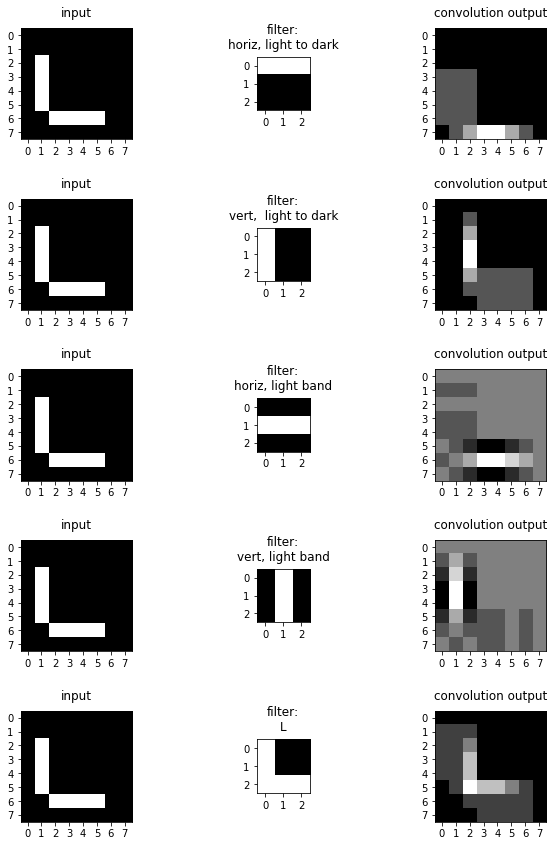

In [4]:
_= cnnh.plot_convs()

- A bright element in the output indicates a high, positive dot product
- A dark element in the output indicates a low (or highly negative) dot product

In our example
- $N = 2$: Two spatial dimensions
- One input feature: $n_{(\ll-1)} = 1$ 
- One output feature $n_\llp = 1$
- $f_\llp = 3$
    - Kernel is $(3 \times 3 \times 1)$.

The template match will be maximized when
- high values in the input correspond to high values in the matching location of the template
- low values in the input correspond to low values in the matching locations of the template

We can have "spatial" dimensions of length even greater than 2

When we want to emphasize the number of features $n_\llp$ rather than the number of spatial dimensions,
we will use ellipsis (dots)
$$\y_{\ldots, n_\llp}$$

where the ellipsis ($\ldots$) is a place-holder for the spatial dimension shape.

In [5]:
print("Done")

Done
